In [3]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# Parameter Estimation

Consider 2 chemical reactions between two chemical species $A$ and  $B$ that have the form
$$ A \leftrightarrow B $$

The balance can shift from $A$ to $B$ by adding heat for example. This is a classical simplified model
of water sewage.

One can write a system of differential equations that describe the reaction as
\begin{eqnarray}
&& {\frac {dA}{dt}} = - \beta A B + \gamma B \\
&& {\frac {dB}{dt}}    = \beta A B - \gamma B \\
&& A(0) = A_0 \quad \quad B(0) = B_0
\end{eqnarray}

To model this we can use the forward Euler method

In [4]:
def ChemReac(beta,gamma,A,B):
    
    F = torch.zeros(2)
    F[0] = -beta*A*B + gamma*B
    F[1] = beta*A*B - gamma*B
    
    return F

In [5]:
def ChemReacTime(beta,gamma,A0,B0,dt,nt):
    
    A = torch.zeros(nt+1); B = torch.zeros(nt+1)
    A[0] = A0; B[0] = B0
    for i in range(nt):
        F = ChemReac(beta,gamma,A[i],B[i])
        A[i+1] = A[i] + dt*F[0]
        B[i+1] = B[i] + dt*F[1]
        
    return A, B    
        

In [6]:
A0 = 0; B0 = 1;
beta = 2.7; gamma = 1;
dt = 0.01; nt = 100
A, B = ChemReacTime(beta,gamma,A0,B0,dt,nt)

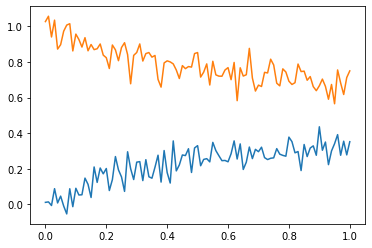

In [7]:
t = np.arange(nt+1); t = t*dt

# Add noise to the data
ndata = A.shape
nA = torch.randn(ndata[0])*0.05
nB = torch.randn(ndata[0])*0.05

Aobs = A+nA; Bobs = B+nB

# This is what we observe
plt.plot(t,Aobs)
plt.plot(t,Bobs)



# Estimating $\beta$ and $\gamma$ from the data

In order to do that we can define a loss function

In [8]:
def loss(beta,gamma,Aobs,Bobs,nt,dt):
    
    Acomp, Bcomp = ChemReacTime(beta,gamma,A0,B0,dt,nt)
    phi = torch.sum((Acomp-Aobs)**2) + torch.sum((Bcomp-Bobs)**2)
    
    return phi

# Let us experiment with this loss
Try a few values of $\beta$ and $\gamma$ and see which one is preferable

In [9]:
beta = 0.1; gamma = 0.3; print(loss(beta,gamma,Aobs,Bobs,nt,dt))

tensor(2.2988)


We can even do it on a grid so we can plot the function


In [10]:
Phi = torch.zeros(64,64)
b = np.arange(64)/64.0; g = np.arange(64)/16.0;
for i in range(64):
    for j in range(64):
        t = loss(b[i],g[j],Aobs,Bobs,nt,dt)        
        Phi[i,j] = t

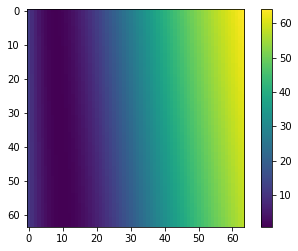

In [11]:
plt.imshow(Phi)
plt.colorbar()

As we can see, finding the minimum of the function using brute force  is computationally expensive. The cost becomes very large in more than 2D.  

Another way to do this  is to use optimization. To this end we use the steepest descent method that reads
$$ \theta_{j+1} \leftarrow \theta_j - \mu_j \nabla F(\theta_j). $$

where $\theta = [\beta, \gamma]$ are the parameters we optimize on and $F(\theta)$ is the loss function.

We now discuss the computation of defivatives using PyTorch


# Automatic Differentiation Using PyTorch

Assuming we have a simple function that we can write in python
$$ f(x) = \frac 12 \sum x_i^2. $$

The derivative is simply
$$ \nabla f(x) = x. $$

We now see how to code the function and the gradient

In [12]:
# define the function
def SumOfSquares(x):
    return 0.5*torch.sum(x**2)

In [13]:
# test the function
x = torch.tensor([0,1,2,3.0])
y = SumOfSquares(x)
print(y)

tensor(7.)


In [14]:
# Now we compute gradients
x = torch.tensor([0,1,2,3.0], requires_grad=True)
y = SumOfSquares(x)

# Differentiate y, the gradient wrt x is stored in x
y.backward()
grady = x.grad

print(grady)


tensor([0., 1., 2., 3.])


# Class assignment

Use AD to compute the gradients of the loss with respect to the parameters in the example of chemical mixing and compare it to finite difference calculations

# Gradients and Steepest Descent

We have shown that a way to minimize the function can be achieved by the steepest descent algorithm that reads

for j=1,...
    Compute $f(\theta_j)$ and $\nabla f(\theta_j)$ 
    
    Take a step $\theta_{j+1} = \theta_j - \mu \nabla f(\theta_j)$ 
    
    Check for convergence

# Class/Home  assignment

Code the steepest descent and using it find the minimum of the function

$$ f(\theta) = (1-\theta_1)^2 + 100(\theta_2 -\theta_1^2)^2 $$

In [97]:
def f(theta1, theta2):
    out = (1 - theta1)**2 + 100*(theta2 - theta1**2)**2
    return out

In [130]:
f(1,1)

0

In [133]:
N=100
domain1 = (0, 2)
domain2 = (0, 2)
out = torch.zeros(N,N)
for i, theta1 in enumerate(torch.linspace(domain1[0], domain1[1], N)):
    for j, theta2 in enumerate(torch.linspace(domain2[0], domain2[1], N)):
        out[i,j] = f(theta1, theta2)

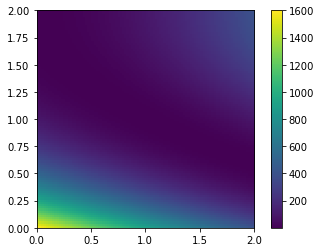

In [145]:
plt.imshow(out.numpy(), extent=(domain1[0], domain1[1], domain2[0], domain2[1]))
plt.colorbar()

In [80]:
torch.linspace(0, 10, 10)

tensor([ 0.0000,  1.1111,  2.2222,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
         8.8889, 10.0000])

In [81]:
theta1 = torch.rand(1, requires_grad=True)
theta2 = torch.rand(1, requires_grad=True)
print(theta1)
print(theta2)

tensor([0.3121], requires_grad=True)
tensor([0.5786], requires_grad=True)


In [82]:
y = f(theta1, theta2)
print(y)

y.backward()
dy_dtheta1 = theta1.grad
dy_dtheta2 = theta2.grad
print(dy_dtheta1)
print(dy_dtheta2)

tensor([0.7047], grad_fn=<AddBackward0>)
tensor([-1.9765])
tensor([0.9624])


In [83]:
mu = 0.001

In [95]:
with torch.no_grad():
    theta1 = theta1 - mu*dy_dtheta1
    theta2 = theta2 - mu*dy_dtheta2
theta1.requires_grad = True
theta2.requires_grad = True
theta2

tensor([0.5728], requires_grad=True)

In [96]:
y = f(theta1, theta2)
print(y)

y.backward()
dy_dtheta1 = theta1.grad
dy_dtheta2 = theta2.grad
print(dy_dtheta1)
print(dy_dtheta2)

tensor([0.6759], grad_fn=<AddBackward0>)
tensor([-1.9584])
tensor([0.9357])


In [160]:
# Everything above this we covered in class, below I put it together into a solution. 
# Putting it all together, I didnt show them this
theta1 = torch.rand(1, requires_grad=True)
theta2 = torch.rand(1, requires_grad=True)

num_iter = 10000
mu = 1e-3
for i in range(num_iter):
    
    y = f(theta1, theta2)  
    y.backward()
    
    if (i < 10) or (i%100 == 0):
        print('Iter : %4d,   Loss : %6.4f, theta1: %6.4f, theta2: %6.4f' % (i, y.item(), theta1.item(), theta2.item()))
    
    with torch.no_grad():
        dy_dtheta1 = theta1.grad
        dy_dtheta2 = theta2.grad
          
        theta1.data = theta1 - mu*dy_dtheta1
        theta2.data = theta2 - mu*dy_dtheta2
        
        theta1.grad.fill_(0.0)
        theta2.grad.fill_(0.0)
          

Iter :    0,   Loss : 0.7597, theta1: 0.7486, theta2: 0.6439
Iter :    1,   Loss : 0.1291, theta1: 0.7741, theta2: 0.6272
Iter :    2,   Loss : 0.0537, theta1: 0.7832, theta2: 0.6216
Iter :    3,   Loss : 0.0460, theta1: 0.7862, theta2: 0.6200
Iter :    4,   Loss : 0.0453, theta1: 0.7872, theta2: 0.6196
Iter :    5,   Loss : 0.0451, theta1: 0.7876, theta2: 0.6197
Iter :    6,   Loss : 0.0451, theta1: 0.7878, theta2: 0.6198
Iter :    7,   Loss : 0.0450, theta1: 0.7880, theta2: 0.6200
Iter :    8,   Loss : 0.0450, theta1: 0.7881, theta2: 0.6202
Iter :    9,   Loss : 0.0449, theta1: 0.7882, theta2: 0.6204
Iter :  100,   Loss : 0.0405, theta1: 0.7989, theta2: 0.6373
Iter :  200,   Loss : 0.0363, theta1: 0.8098, theta2: 0.6549
Iter :  300,   Loss : 0.0325, theta1: 0.8199, theta2: 0.6714
Iter :  400,   Loss : 0.0292, theta1: 0.8293, theta2: 0.6870
Iter :  500,   Loss : 0.0263, theta1: 0.8381, theta2: 0.7017
Iter :  600,   Loss : 0.0237, theta1: 0.8463, theta2: 0.7155
Iter :  700,   Loss : 0.

In [128]:
theta1

tensor([-0.0603], requires_grad=True)

In [115]:
y = f(theta1, theta2)

In [116]:
y.backward()

In [117]:
theta1.grad